# P2: Low and High Pass Filters

## Will Koehrsen wjk68

In [18]:
import numpy as np
import pandas as pd

import scipy

from scipy import fftpack

import cv2

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize

figsize(10, 8)

# Original Image

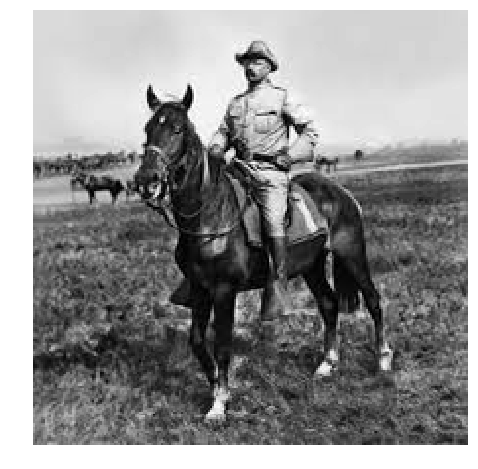

In [22]:
image = Image.open('img/ex.jpg')
image = image.resize((221, 221), 1)
image = image.convert('L')
image = np.array(image, dtype=np.float)
plt.imshow(image, cmap='gray')
plt.axis('off');

# Functions for DCT and IDCT

Equation for [Discrete Cosine Transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform):

$$X_k = \sum_{n=0}^{N-1} x_n cos[\frac{\pi}{N} (n + \frac{1}{2}) k]$$

with: 

$$k = 0, \ldots, N-1$$


In [23]:
def get_2D_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm = 'ortho').T, norm = 'ortho')

def get_2D_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm = 'ortho').T, norm = 'ortho')

def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    return img

# Get Reconstructed Images Selecting Zeroing Out Components

In [24]:
dct_size = image.shape[0]
dct = get_2D_dct(image)
recon_images = []

for ii in range(dct_size):
    dct_copy = dct.copy()
    dct_copy[ii:, :] = 0
    dct_copy[:, ii:] = 0
    
    r_img = get_2D_idct(dct_copy)
    recon = get_reconstructed_image(r_img)
    
    recon_images.append(recon)

# Visualize the Amplitude of DCT Coefficients

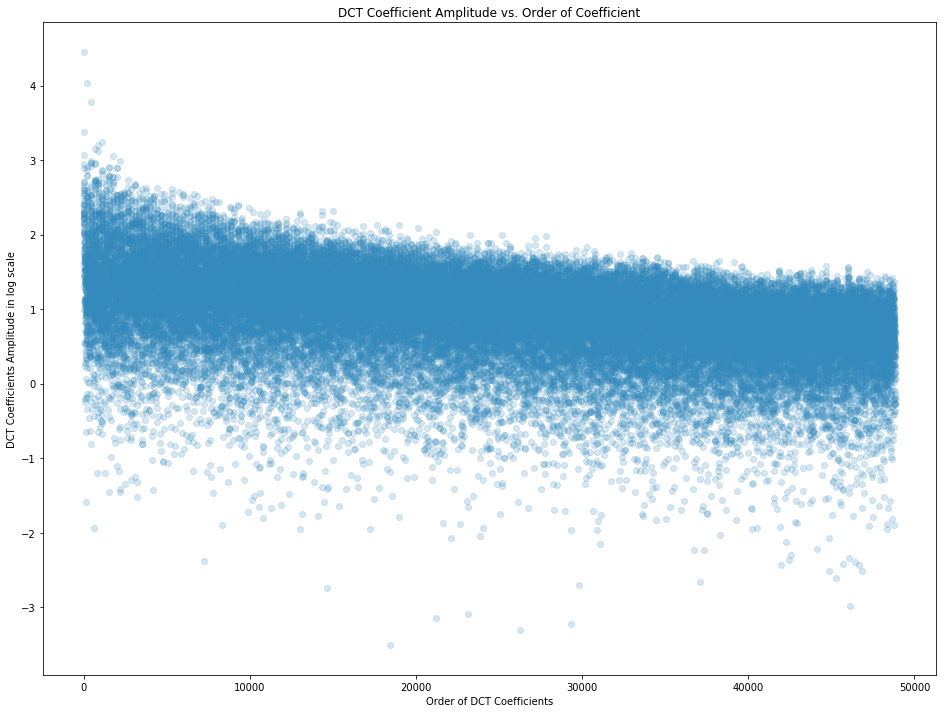

In [25]:
plt.figure(figsize=(16, 12));
plt.scatter(range(dct.ravel().size), np.log10(np.abs(dct.ravel())), c='#348ABD', alpha=.2);
plt.title('DCT Coefficient Amplitude vs. Order of Coefficient');
plt.xlabel('Order of DCT Coefficients');
plt.ylabel('DCT Coefficients Amplitude in log scale');

# Visualize the Distribution of DCT Coefficients

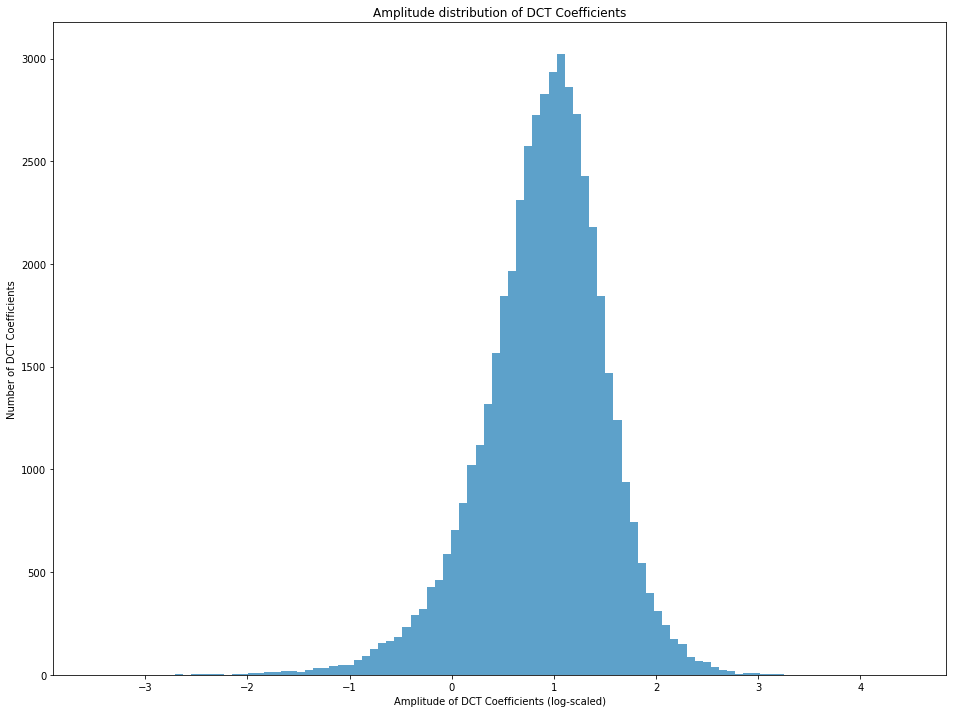

In [26]:
plt.figure(figsize=(16, 12))
plt.hist(np.log10(np.abs(dct.ravel())), bins=100, color='#348ABD', alpha=0.8, histtype='stepfilled');
plt.xlabel('Amplitude of DCT Coefficients (log-scaled)');
plt.ylabel('Number of DCT Coefficients');
plt.title('Amplitude distribution of DCT Coefficients');

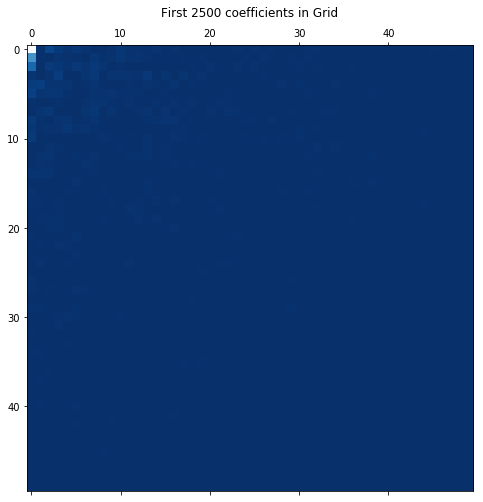

In [27]:
plt.matshow(np.abs(dct[:50, :50]), cmap=plt.cm.Blues_r);
plt.title('First 2500 coefficients in Grid');

The low-frequency coeffiecients have a much greater magnitude. This suggests we could compress the image by retaining the lower frequencies and discarding the higher frequencies which do not contribute much to the image. This is how [JPEG compresses images](https://en.wikipedia.org/wiki/JPEG).

# Low Pass Filter

We can view the low-frequency images by showing the images with only the first 64 coefficients. These preserve the low frequencies while attenuating the high frequencies.

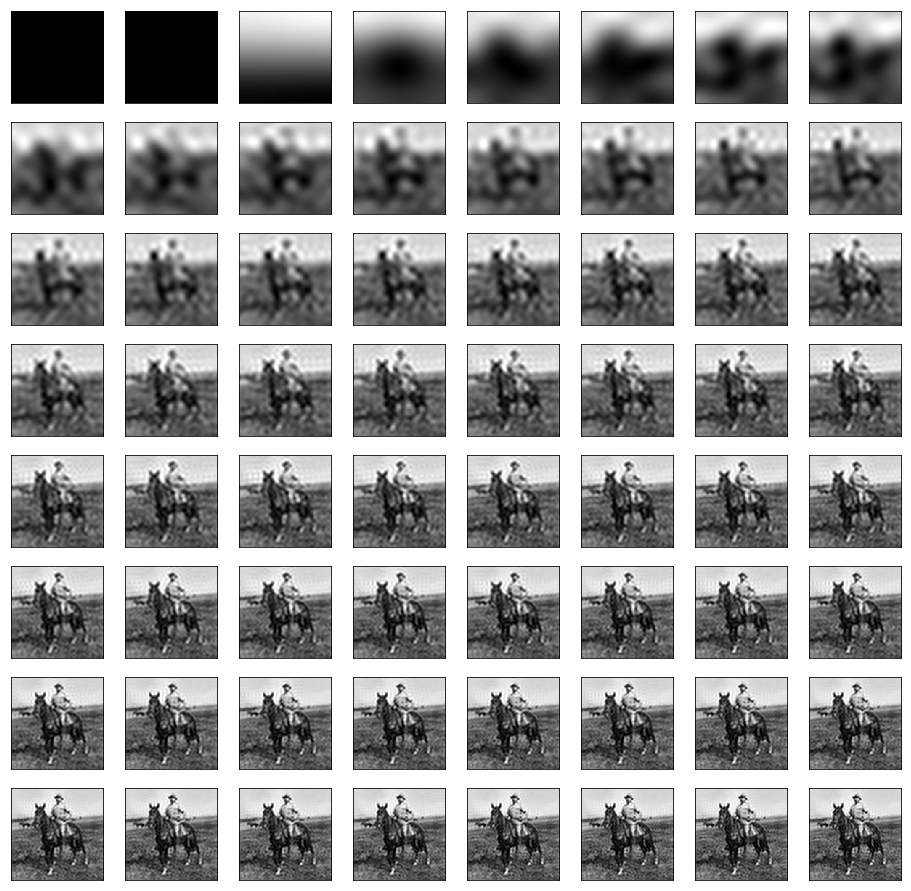

In [28]:
fig = plt.figure(figsize=(16, 16))
for ii in range(64):
    plt.subplot(8, 8, ii + 1)
    plt.imshow(recon_images[ii], cmap=plt.cm.gray)
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);

As can be seen, the first ~64 coefficients appear to be enough to represent the entire image. We could compress the image by retaining only the first n number of coefficients with minimal loss. To share an image, we can just send the coefficients and the image can be reconstructed using the DCT basis functions at the other end. This shows the benefits of having a complete, common basis so just the coefficients can be passed and not the pixel values. 

# High Pass Filter

To view the high-frequency components, we repeat the process but with the low coefficients zeroed out. Here are the final 64 images that capture the high-frequency components. 

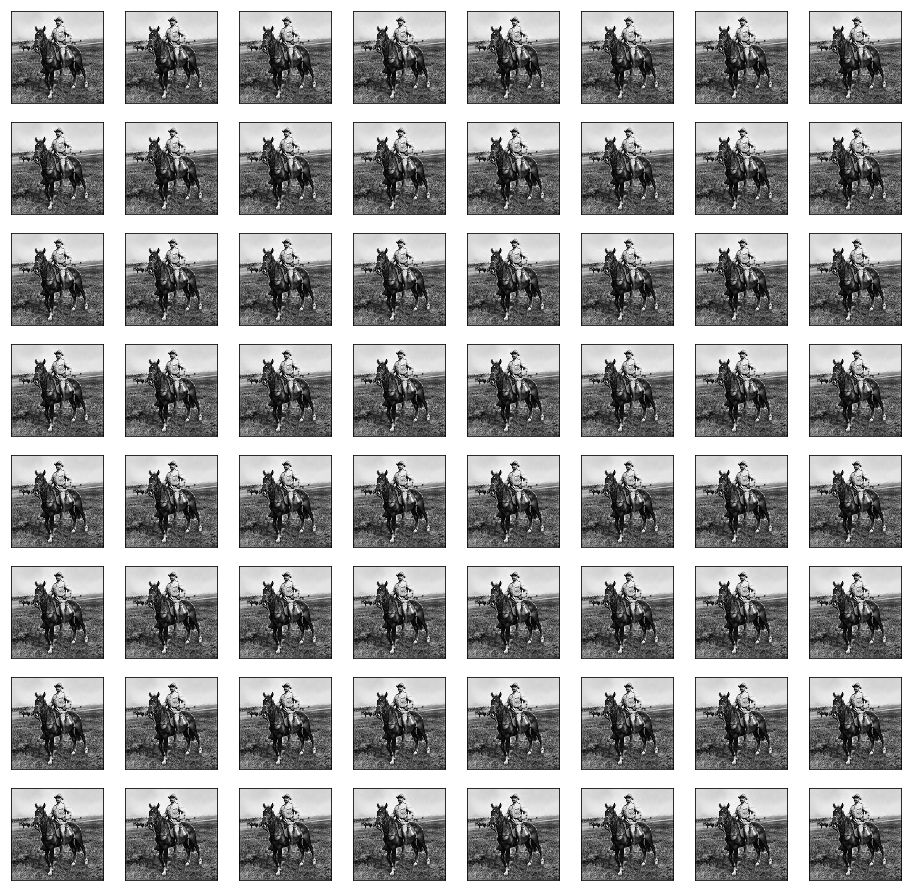

In [29]:
fig = plt.figure(figsize=(16, 16))
for ii in range(156, 220):
    plt.subplot(8, 8, ii - 156 + 1)
    plt.imshow(recon_images[ii], cmap=plt.cm.gray)
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);

# Animated GIF of Reconstruction

We can make an animation showing the effects of adding in each of the 221 basis coefficients by making an animation. Here, we start out only including the 0th coefficient, and add in one coefficient at a time until we are accounting for all the coefficients. The first image includes only the 0th coefficient, in location 0, 0, the second includes the 0th coefficient and the ones in locations (1,0), (0,1), and (1, 1) the next includes (0,0) to (2, 2) and so on until we include all the coefficients (221, 221).

In [34]:
new_image = np.zeros(image.shape)
for i in range(221):
    new_image += recon_images[i]
    plt.imsave('img/frames/%d.png' % i, new_image, cmap = 'gray')

I am using ImageMagick to create the animation. I have placed all
the individual images in a folder and use the following
command to create a gif of all images.

```magick -quality 100 *.png reconstruct.gif```

# Animation

![](img/frames/reconstruct.gif)

# Conclusions

In this notebook, we saw how we can selectively zero out coefficients to retain only the low frequency components or only the high frequency components. The technique of DCT (of DFT) allows us to compress images by performing the transform, removing the low-magnitude coefficients, sharing the coefficients, and having the target machine reconstruct the image using the inverse DCT. This shows the benefits of constructing a complete, common basis. Rather than representing the image as pixel intensity values, we can represent the image as the dct coefficients at each pixel. The technique of representing an image as a set of amplitude responses to different spatial frequencies is known as space-frequency analysis.